In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [2]:
# чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

# Baseline Prophet

In [3]:
# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

01:23:10 - cmdstanpy - INFO - Chain [1] start processing
01:23:11 - cmdstanpy - INFO - Chain [1] done processing


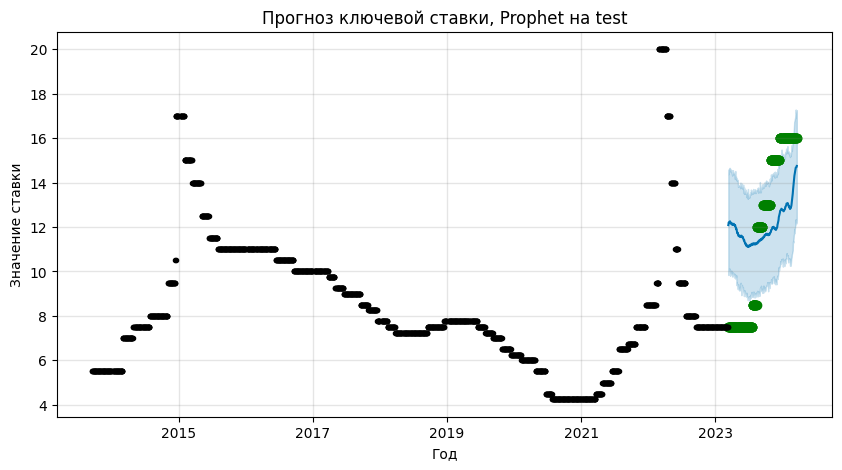

In [4]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

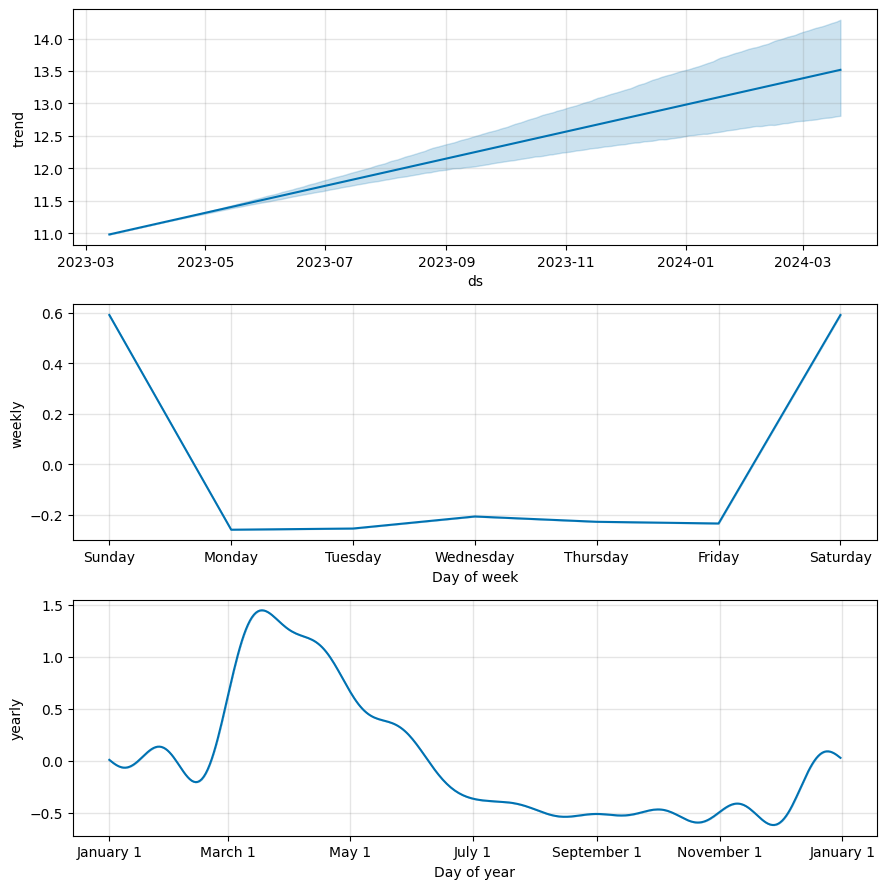

In [5]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [6]:
# выводиим метрики для оценкии baseline prophet 
metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.921184,0.300426,10.003578,3.162843


1. Mean Absolute Error (MAE) - Среднее абсолютное отклонение позволяет оценить среднее абсолютное отклонение прогнозов от фактических значений. Чем ниже MAE, тем лучше модель.
2. Mean Absolute Percentage Error (MAPE) - Среднее абсолютное процентное отклонение показывает средний процент ошибки прогноза от фактических значений. Чем ниже MAPE, тем лучше.
3. Mean Squared Error (MSE) - Среднеквадратичное отклонение предоставляет информацию о среднеквадратичном отклонении прогнозов от фактических значений. Чем ниже MSE, тем лучше модель.
4. Root Mean Squared Error (RMSE) - Квадратный корень из MSE помогает интерпретировать стандартное отклонение прогнозов от фактических значений.

# Tuning Prophet

## Cross validation

In [7]:
# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [8]:
# Осуществить кросс-валидацию
df_cv = cross_validation(bl_prophet, initial='730 days', period='90 days', horizon='365 days')

# Рассчитать метрики производительности
df_metrics = performance_metrics(df_cv)

  0%|          | 0/27 [00:00<?, ?it/s]

01:23:12 - cmdstanpy - INFO - Chain [1] start processing
01:23:13 - cmdstanpy - INFO - Chain [1] done processing
01:23:13 - cmdstanpy - INFO - Chain [1] start processing
01:23:13 - cmdstanpy - INFO - Chain [1] done processing
01:23:13 - cmdstanpy - INFO - Chain [1] start processing
01:23:14 - cmdstanpy - INFO - Chain [1] done processing
01:23:14 - cmdstanpy - INFO - Chain [1] start processing
01:23:14 - cmdstanpy - INFO - Chain [1] done processing
01:23:15 - cmdstanpy - INFO - Chain [1] start processing
01:23:15 - cmdstanpy - INFO - Chain [1] done processing
01:23:15 - cmdstanpy - INFO - Chain [1] start processing
01:23:15 - cmdstanpy - INFO - Chain [1] done processing
01:23:16 - cmdstanpy - INFO - Chain [1] start processing
01:23:16 - cmdstanpy - INFO - Chain [1] done processing
01:23:16 - cmdstanpy - INFO - Chain [1] start processing
01:23:17 - cmdstanpy - INFO - Chain [1] done processing
01:23:17 - cmdstanpy - INFO - Chain [1] start processing
01:23:18 - cmdstanpy - INFO - Chain [1]

In [9]:
# выводиим метрики для оценкии tuning prophet 
metrics = pd.concat([metrics, get_metrics(y_test=df_cv['y'], y_pred=df_cv['yhat'], name='CV Prophet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.921184,0.300426,10.003578,3.162843
0,CV Prophet,2.071934,0.251581,10.791053,3.284974


In [10]:
m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(df_train)

01:23:40 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=pred_days)
forecast = m.predict(future)

In [23]:
m

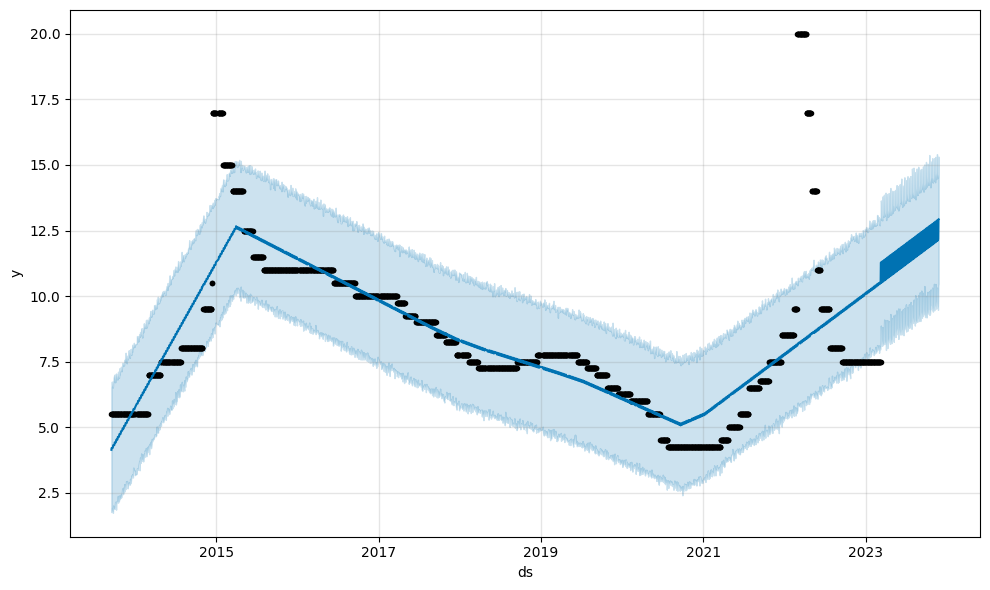

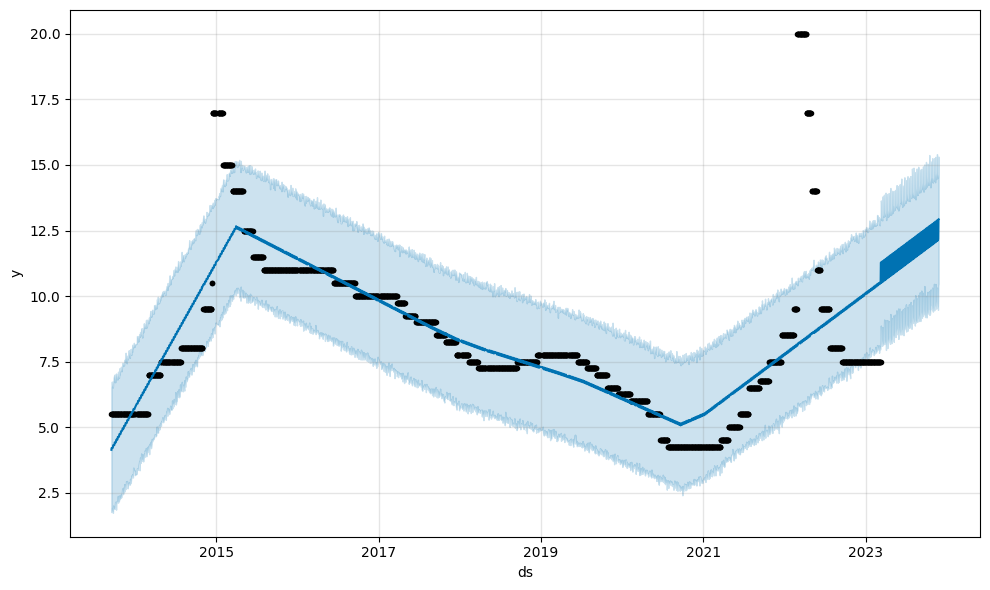

In [12]:
# Смотрим, что предсказалось
m.plot(forecast)

In [14]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [16]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-pred_days:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-pred_days:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  nan %
MAE (средняя абсолютная ошибка) –  nan


In [17]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 90
final_train_df = df
f = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

01:30:23 - cmdstanpy - INFO - Chain [1] start processing
01:30:23 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
final_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-09-17,4.527620,1.521753,6.781927,4.527620,4.527620,-0.198652,-0.198652,-0.198652,-0.198652,-0.198652,-0.198652,0.0,0.0,0.0,4.328968
1,2013-09-18,4.542428,1.742960,7.140866,4.542428,4.542428,-0.153838,-0.153838,-0.153838,-0.153838,-0.153838,-0.153838,0.0,0.0,0.0,4.388590
2,2013-09-19,4.557235,1.831221,6.941484,4.557235,4.557235,-0.178642,-0.178642,-0.178642,-0.178642,-0.178642,-0.178642,0.0,0.0,0.0,4.378593
3,2013-09-20,4.572043,1.709292,6.987056,4.572043,4.572043,-0.199540,-0.199540,-0.199540,-0.199540,-0.199540,-0.199540,0.0,0.0,0.0,4.372503
4,2013-09-23,4.616466,1.930940,6.898005,4.616466,4.616466,-0.216361,-0.216361,-0.216361,-0.216361,-0.216361,-0.216361,0.0,0.0,0.0,4.400105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,2024-06-14,13.433103,10.817992,15.850098,13.390339,13.489373,-0.199540,-0.199540,-0.199540,-0.199540,-0.199540,-0.199540,0.0,0.0,0.0,13.233563
2705,2024-06-15,13.438560,11.449486,16.457394,13.392555,13.497363,0.473516,0.473516,0.473516,0.473516,0.473516,0.473516,0.0,0.0,0.0,13.912077
2706,2024-06-16,13.444018,11.336294,16.394715,13.396954,13.504347,0.473516,0.473516,0.473516,0.473516,0.473516,0.473516,0.0,0.0,0.0,13.917534
2707,2024-06-17,13.449475,10.788329,15.845852,13.401775,13.510928,-0.216361,-0.216361,-0.216361,-0.216361,-0.216361,-0.216361,0.0,0.0,0.0,13.233114


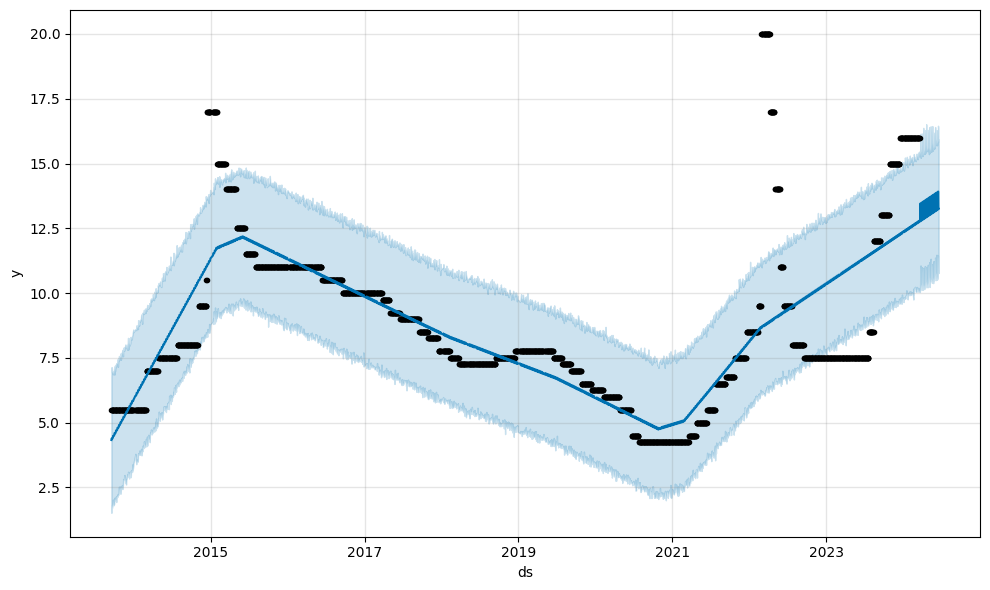

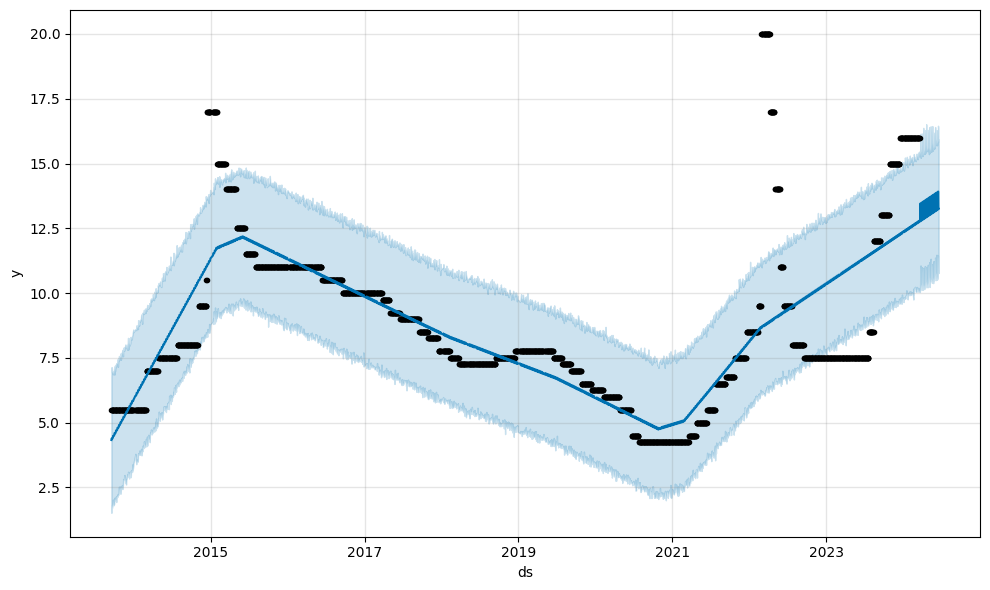

In [19]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast)

In [20]:
# Рисуем график с границами прогноза на полном периоде
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])